# Basic Training and Prediction with CNNs
This notebook demonstrates the basic use of OpenSoundscape's `preprocessors` and `cnn` modules for 

- training CNNs
- making predictions using CNNs 

Convolutional Neural Networks (CNNs) are a popular tool for developing automated machine learning classifiers on images or image-like samples. By converting audio into two-dimensional frequency vs time representations such as a spectrogram, we can generate image-like samples that can be used to train CNNs. 

Under the hood, OpenSoundscape uses Pytorch for machine learning tasks. By using OpenSoundscape's CNN classes such as Resnet18Multiclass in combination with preprocessor classes such as CNNPreprocessor, you can train and predict with PyTorch's powerful CNN architectures. 

First, let's import some utilities

In [1]:
# Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learing model
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor

# the cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape.torch.models.cnn import Resnet18Multiclass, Resnet18Binary

#other utilities and packages
from opensoundscape.helpers import run_command
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

set manual seeds for pytorch and python - you probably don't want to do this when you actually train your model, but it's useful for debugging

In [2]:
torch.manual_seed(0)
random.seed(0)

## Prepare audio data

### Download labeled audio files

Training a machine learning model requires some pre-labeled data. These data, in the form of audio recordings or spectrograms, are labeled with whether or not they contain the sound of the species of interest. These data can be obtained from online databases such as Xeno-Canto.org, or by labeling one's own ARU data using a program like Cornell's "Raven" sound analysis software.

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `curl` and `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. Download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

**Note**: Once you have the data, you do not need to run this cell again.

In [3]:
commands = [
    "curl -L https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz -o ./woodcock_labeled_data.tar.gz",
    "tar -xzf woodcock_labeled_data.tar.gz", # Unzip the downloaded tar.gz file
    "rm woodcock_labeled_data.tar.gz" # Remove the file after its contents are unzipped
]
for command in commands:
    run_command(command)

### generate 1-hot encoded labels 

The folder contains 2s long audio clips taken from an autonomous recording unit. It also contains a file `woodcock_labels.csv` which contains the names of each file and its corresponding label information, created using a program called [Specky](https://github.com/rhine3/specky).

We first manipulate the label dataframe to give "one hot" labels - that is, a column for every class, with 1 for present or 0 for absent in each sample's row. In this case, our classes are simply 'negative' for files without a woodcock and 'positive' for files with a woodcock.  Note that these classes are mutually exclusive, so we have a "single-target" problem (as opposed to a "multi-target" problem where multiple classes can simultaneously be present). 

In [4]:
#load Specky output: a table of labeled audio files
labels = pd.read_csv(Path("woodcock_labeled_data/woodcock_labels.csv"))

#update the paths to the audio files
labels.filename = ['./woodcock_labeled_data/'+f for f in labels.filename]

#generate "one-hot" labels
labels['negative']=[0 if label=='present' else 1 for label in labels['woodcock']]
labels['positive']=[1 if label=='present' else 0 for label in labels['woodcock']]

#use the file path as the index, and class names as the only columns
classes = ['negative','positive']
labels = labels.set_index('filename')[classes]
labels.head()

,negative,positive
filename,,
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,0,1
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,1,0
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,0,1
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0,1
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,0,1


### split into training and validation sets
We simply use a utility from sklearn to randomly divide the labeled samples between two sets. The first set `train_df` will be used to train the CNN, while the second set `valid_df` will be used to test how well the model can predict the classes of samples that it was not trained with. 

In [5]:
from sklearn.model_selection import train_test_split
train_df,valid_df = train_test_split(labels,test_size=0.2,random_state=1)

## Preprocessors
The CnnPreprocessor loads audio files, creates spectrograms, performs various augmentations, and returns a pytorch Tensor.

The AudioToSpectrogramPreprocessor loads audio files, creates spectrograms, and returns a pytorch Tensor (no augmentation). 

A Preprocessor must be initialized with a very specific dataframe: 
- the index of the dataframe provides paths to audio samples
- the columns are the class names
- the values are 0 (absent/False) or 1 (present/True) for each sample and each class.

All of the steps in the preprocessing pipeline can be modified or skipped by modifying the preprocessor's `.actions`. For details on how to modify and customize a preprocessor, see the `preprocessing` notebook/tutorial. 

### create preprocessors for train_df and valid_df

In [23]:
from opensoundscape.preprocess.preprocessors import CnnPreprocessor

train_dataset = CnnPreprocessor(train_df)

valid_dataset = CnnPreprocessor(valid_df)

### inspect training images
It's always a good idea to make sure the images coming out of the preprocessor look like you expect them to. Here we generate images for a few samples.

In [24]:
# helper function for displaying a sample as an image 
def show_tensor(sample):
    plt.imshow((sample['X'][0,:,:]/2+0.5)*-1,cmap='Greys',vmin=-1,vmax=0)
    plt.show()

load 3 random samples, printing the labels and image for each

labels: tensor([0, 1])


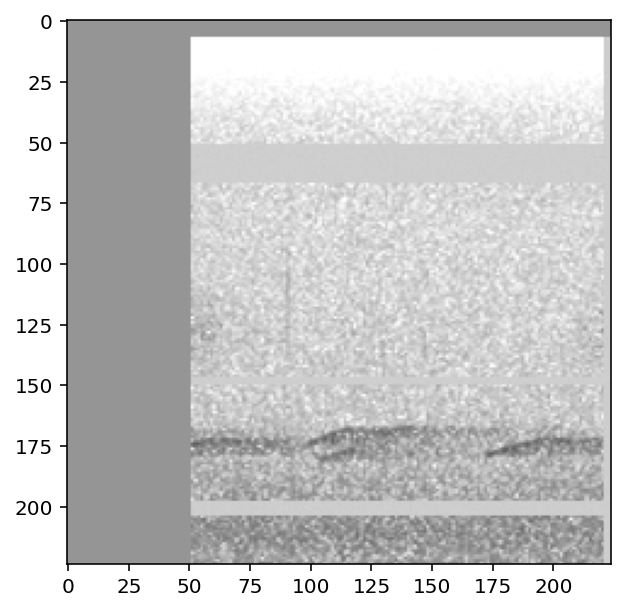

labels: tensor([0, 1])


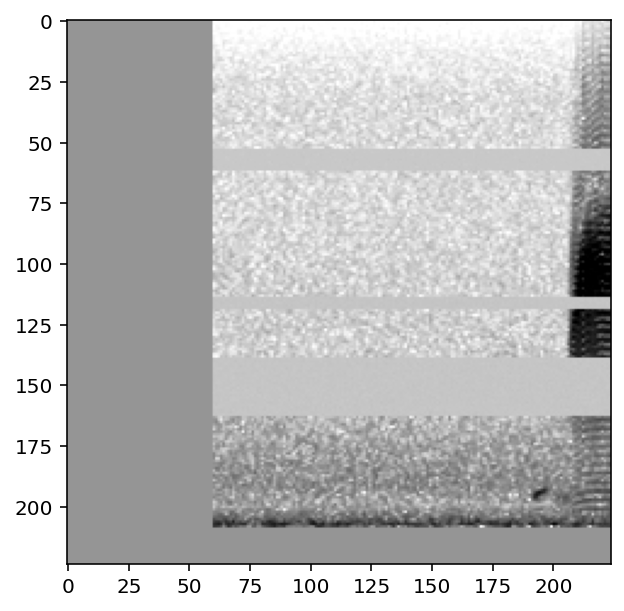

labels: tensor([1, 0])


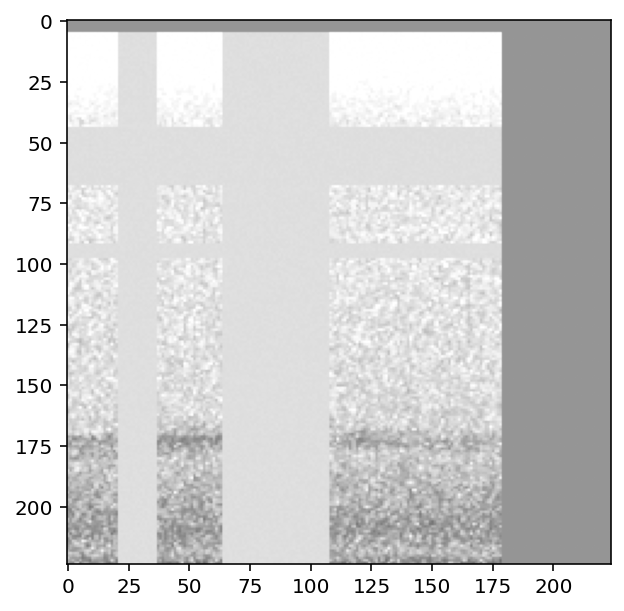

labels: tensor([0, 1])


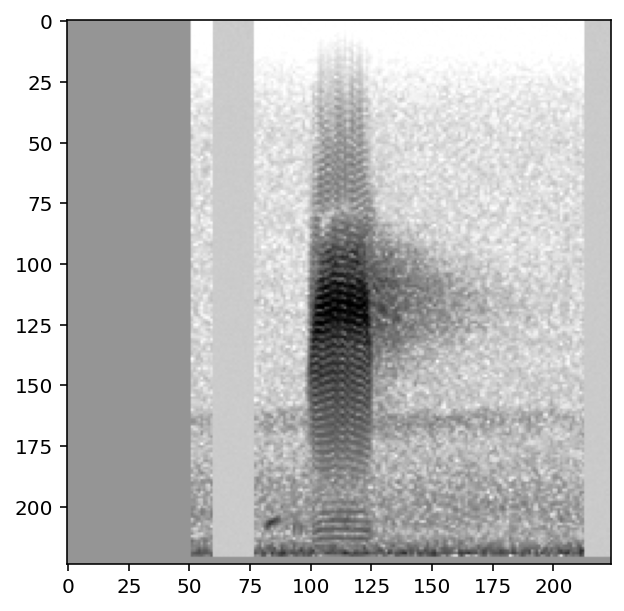

In [25]:
for i, d in enumerate(train_dataset.sample(n=4)):
    print(f"labels: {d['y']}")
    show_tensor(d)

let's turn all augmentation off to see how that changes the generated images

labels: tensor([0, 1])


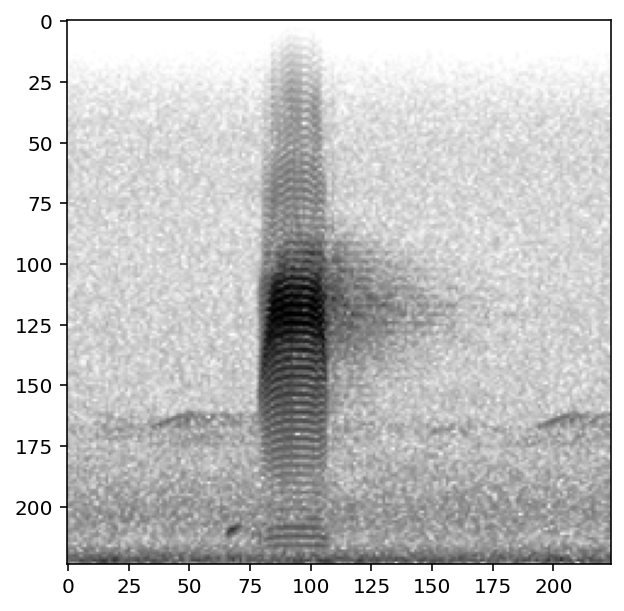

labels: tensor([0, 1])


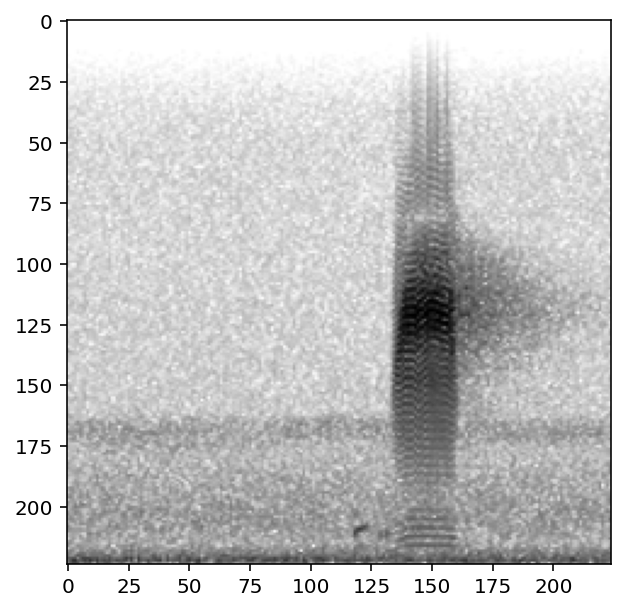

labels: tensor([0, 1])


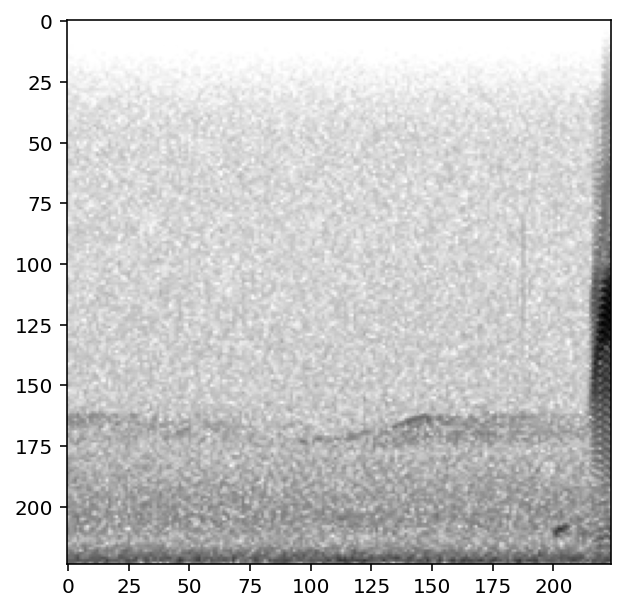

In [26]:
train_dataset.augmentation_off()
for i, d in enumerate(train_dataset.sample(n=3)):
    print(f"labels: {d['y']}")
    show_tensor(d)

## Train a binary (2-class) model
Now, we create a cnn model object and train it on the train_dataset

depending on the speed of your computer, training the cnn may take a few minutes. 

**Note**: We'll only train for 5 epochs on this small dataset as a demonstration, but you'll probably need to train for hundreds of epochs on hundreds of training files to create a useful model. 

In [27]:
# Create model object
model = Resnet18Binary(classes)

model.train(train_dataset,train_dataset,save_path='.',epochs=5,batch_size=8,save_interval=100,num_workers=0)

created PytorchModel model object with 2 classes
Epoch: 0 [batch 0/3 (0.00%)] 
	Jacc: 0.375 Hamm: 0.250 DistLoss: 0.696

Validation.
(23, 2)
	 Precision: 0.7391304347826086
	 Recall: 1.0
	 F1: 0.85
Updating best model
Saving to best.model
Epoch: 1 [batch 0/3 (0.00%)] 
	Jacc: 0.500 Hamm: 0.000 DistLoss: 0.279


/Users/SML161/Library/Caches/pypoetry/virtualenvs/opensoundscape-HOFcj3f8-py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(23, 2)
	 Precision: 0.9375
	 Recall: 0.8823529411764706
	 F1: 0.9090909090909091
Updating best model
Saving to best.model
Epoch: 2 [batch 0/3 (0.00%)] 
	Jacc: 0.750 Hamm: 0.125 DistLoss: 0.284

Validation.
(23, 2)
	 Precision: 0.7391304347826086
	 Recall: 1.0
	 F1: 0.85
Epoch: 3 [batch 0/3 (0.00%)] 
	Jacc: 0.500 Hamm: 0.000 DistLoss: 0.099


/Users/SML161/Library/Caches/pypoetry/virtualenvs/opensoundscape-HOFcj3f8-py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(23, 2)
	 Precision: 0.7391304347826086
	 Recall: 1.0
	 F1: 0.85
Epoch: 4 [batch 0/3 (0.00%)] 
	Jacc: 0.500 Hamm: 0.000 DistLoss: 0.030


/Users/SML161/Library/Caches/pypoetry/virtualenvs/opensoundscape-HOFcj3f8-py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(23, 2)
	 Precision: 0.8947368421052632
	 Recall: 1.0
	 F1: 0.9444444444444444
Saving weights, metrics, and train/valid scores.
Saving to epoch-4.model
Updating best model
Saving to best.model

Best Model Appears at Epoch 4 with F1 0.944.


### Loss historgy
We can plot the loss from each epoch to check that our loss is declining

Text(0, 0.5, 'loss')

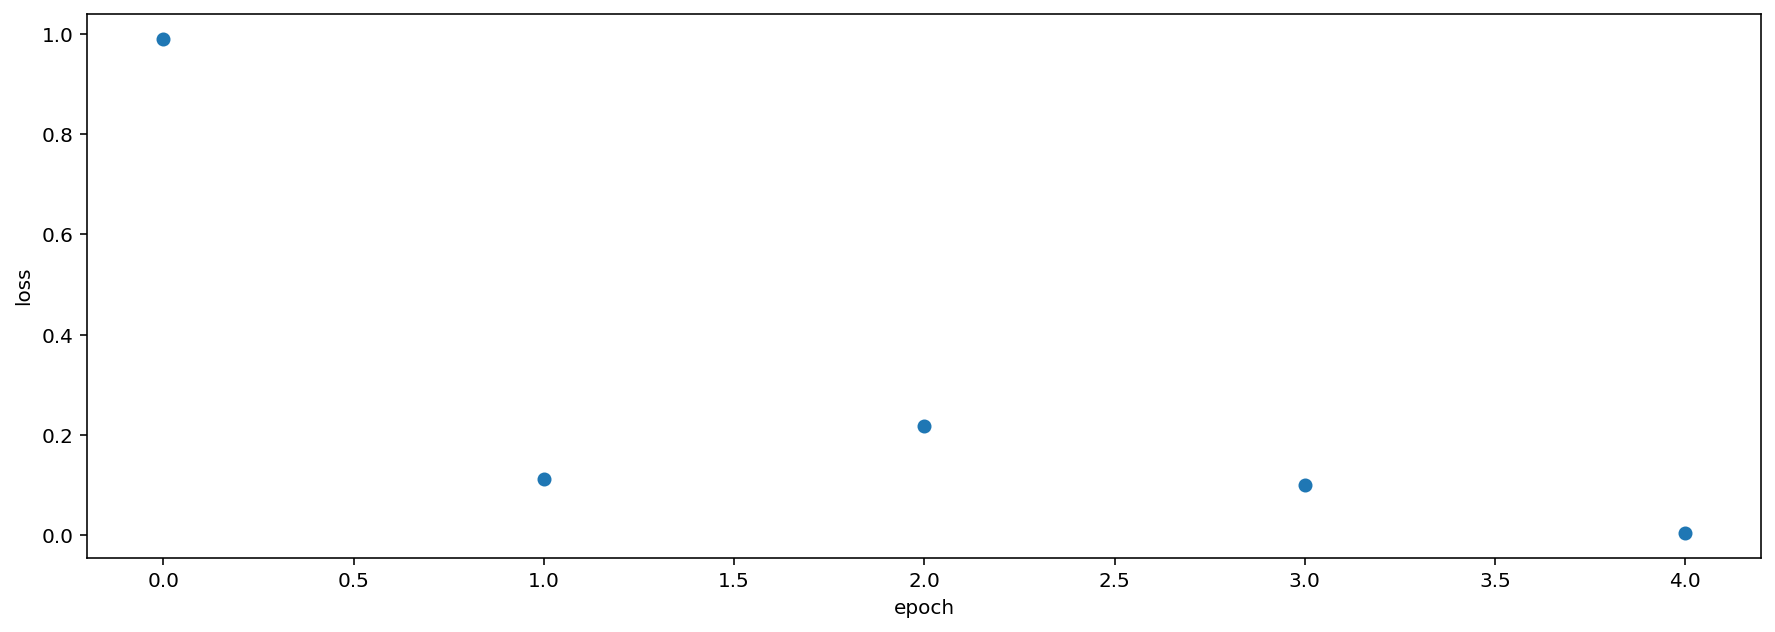

In [14]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')

## Prediction
We haven't actually trained a useful model in 5 epochs, but we can use the trained model to demonstrate how prediction works.

We simply call the .predict() function on a preprocessor instance. It will return three dataframes: 
- scores : numeric predictions from the model for each sample and class
- predictions: 0/1 predictions from the model for each sample and class (only generated if binary_predictions argument is supplied)
- labels: Original labels from the dataset, if available

The dataset can be an instance of any Preprocessor class, as long as it provides the correct tensor shape to the model. To load audio and create a spectrogram without applying any augmentation, we use the class AudioToSpectrogramPreprocessor.

In [15]:
prediction_dataset = AudioToSpectrogramPreprocessor(valid_df)

In [16]:
valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset)
valid_scores_df

(6, 2)


,negative,positive
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,-3.675739,4.610910
./woodcock_labeled_data/92647ab903049a9ee4125abdf7b24f2a.wav,-2.874976,3.605897
./woodcock_labeled_data/75b2f63e032dbd6d197900495a16856f.wav,-3.590667,5.338560
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,-3.025679,4.315912
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,0.357473,0.744905
./woodcock_labeled_data/4afa902e823095e03ba23ebc398c35b7.wav,-4.546519,5.363533


### activation layer
We can modify the final activation layer to change the output of the predict() function - for instance, since we are choosing between two mutually exclusive classes in this case we may want to use the `'softmax'` activation which results in the scores across all classes summing to 1 for each sample. Other options include `'softmax_and_logit'`, `'sigmoid'`, or simply `None` to get the raw outputs of the network. 

In [17]:
valid_scores, valid_preds, valid_labels = model.predict(prediction_dataset, activation_layer='softmax')

(6, 2)


compare the softmax scores to the labels, side-by-side

In [18]:
valid_scores.columns = ['pred_negative','pred_positive']
valid_dataset.df.join(valid_scores).sample(5)

,negative,positive,pred_negative,pred_positive
filename,,,,
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,0,1,0.000648,0.999352
./woodcock_labeled_data/92647ab903049a9ee4125abdf7b24f2a.wav,0,1,0.001530,0.998470
./woodcock_labeled_data/4afa902e823095e03ba23ebc398c35b7.wav,0,1,0.000050,0.999950
./woodcock_labeled_data/75b2f63e032dbd6d197900495a16856f.wav,0,1,0.000132,0.999868
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,0,1,0.000252,0.999748


You may discover that `valid_preds` is currently `None` - this is because we haven't specified an option for the `binary_preds` argument of predict. We can choose between `'single_target'` prediction (always predict the highest scoring class and no others) or `'multi_target'` (predict 1 for all classes exceeding a threshold).

### single-target prediction
always predict the highest scoring class = 1 and all other classes = 0

In [19]:
scores,preds,labels = model.predict(prediction_dataset,binary_preds='single_target')
preds.head()

(6, 2)


,negative,positive
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,0.0,1.0
./woodcock_labeled_data/92647ab903049a9ee4125abdf7b24f2a.wav,0.0,1.0
./woodcock_labeled_data/75b2f63e032dbd6d197900495a16856f.wav,0.0,1.0
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,0.0,1.0
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,0.0,1.0


### multi-target prediction
predict 1 for all classes exceeding a threshold

In [20]:
score_df,pred_df,label_df = model.predict(prediction_dataset,binary_preds='multi_target',threshold=0.3,activation_layer="sigmoid")
pred_df.head()

(6, 2)


,negative,positive
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,0.0,1.0
./woodcock_labeled_data/92647ab903049a9ee4125abdf7b24f2a.wav,0.0,1.0
./woodcock_labeled_data/75b2f63e032dbd6d197900495a16856f.wav,0.0,1.0
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,0.0,1.0
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,1.0,1.0


### Parallelizing prediction

Two parameters can be used to increase training efficiency depending on the computational resources available:

- `num_workers`: Pytorch's method of parallelizing across cores (cpu's) - choose 0 to predict on the root process, or >1 if you want to use more than 1 cpu

- `batch_size`: number of samples to predict on simultaneously



In [21]:
score_df,pred_df,label_df = model.predict(valid_dataset,batch_size=8,num_workers=0,binary_preds='multi_target')

(6, 2)


## train a multi-class model
A multi-class model can have any number of classes, and can be either 
- multi-target: any number of classes can be positive for one sample
- single-target: exactly one class is positive for each sample

In [17]:
from opensoundscape.torch.models.cnn import Resnet18Multiclass
model = Resnet18Multiclass(['negative','positive'])

# by default, Resnet18Multiclass is multi-target. If you want a single-target model, add the line:
#model.single_target = True

created PytorchModel model object with 2 classes


### train
Training looks the same as before. In practice, using larger batch sizes (64+) improves stability and generalizeability of training. 

In [18]:
model.train(train_dataset,valid_dataset,save_path='./multilabel_train/',epochs=1,batch_size=16,save_interval=100,num_workers=0)

Epoch: 0 [batch 0/2 (0.00%)] 
	Jacc: 0.522 Hamm: 0.406 DistLoss: 19.941

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545453
Saving weights, metrics, and train/valid scores.
Saving to multilabel_train/epoch-0.model
Updating best model
Saving to multilabel_train/best.model

Best Model Appears at Epoch 0 with F1 0.455.


### predict
Prediction looks the same as well. Remember to choose the `activation_layer` carefully, and think about whether you need binary_preds=`single_target` or `multi_target` if you want to generate 0/1 predictions for each sample and class. 

In [19]:
train_preds,_,_ = model.predict(train_dataset)
train_preds.columns = ['pred_negative','pred_positive']
train_dataset.df.join(train_preds).head()

(23, 2)


,negative,positive,pred_negative,pred_positive
filename,,,,
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0,1,-3.416934,0.601529
./woodcock_labeled_data/ad90eefb6196ca83f9cf43b6f56c4b4a.wav,0,1,-3.776547,0.200800
./woodcock_labeled_data/e9e7153d11de3ac8fc3f7164d43bac92.wav,0,1,-2.389349,0.491336
./woodcock_labeled_data/c057a4486b25cd638850fc07399385b2.wav,0,1,-2.421409,0.668611
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,0,1,-3.528922,0.538610


## Saving and loading weights

### save
The model saves weights to `self.weights_path` to `epoch-X.model` automatically during training every `save_interval` epochs, and also keeps the file `best.model` updated with the weights that achieve the best F1 score on the validation dataset. You can also save the model manually at any time with model.save(path).

In [20]:
model1 = Resnet18Binary(classes)
model1.train(train_dataset,valid_dataset,epochs=0,save_path='./multilabel_train/')
model1.save('./multilabel_train/my_favorite.model')

created PytorchModel model object with 2 classes

Best Model Appears at Epoch 0 with F1 0.000.
Saving to multilabel_train/my_favorite.model


### load

Models can be loaded from a saved path by either of two methods:
- creating an instance of the model class, then calling `.load()`
- calling the model class's `.from_checkpoint()` method (not implemented for all classes)

Note that in either case, you must know the class of the saved model.

The two methods produce equivalent results:

In [28]:
#create model object then load weights from checkpoint
model = Resnet18Binary(classes)
model.load('./best.model')

created PytorchModel model object with 2 classes
loading weights from saved object


In [29]:
#or, create object directly from checkpoint
model = Resnet18Binary.from_checkpoint('./best.model')

created PytorchModel model object with 2 classes
loading weights from saved object


the model can now be used for prediction (`model.predict()`) or to continue training (`model.train()`)

## Predict using a saved model

using a saved or downloaded model to run predictions on audio files is as simple as 
- creating the model object and loading weights
- runing .predict() on an instance of a preprocessor class, such as AudioToSpectrogramPreprocessor()

In [30]:
# load the saved model
model = Resnet18Binary.from_checkpoint('./best.model')

# create a Preprocessor instance with the audio samples
prediction_dataset = AudioToSpectrogramPreprocessor(valid_df,return_labels=False)

#predict on a dataset
scores,_,_ = model.predict(prediction_dataset, activation_layer='softmax_and_logit')

created PytorchModel model object with 2 classes
loading weights from saved object
(6, 2)


## Continue training from saved model

We can also continue to train a model after loading it from a saved file. 

By default, .load() loads the optimizer parameters and learning rate parameters from the saved model, in adition to the network weights. 

In [31]:
model = Resnet18Binary(classes)
model.load('./best.model') #must be a path to a Resnet18Binary model

#continue training from the checkpoint where the model was saved
model.train(train_dataset,valid_dataset,save_path='.',epochs=0)

created PytorchModel model object with 2 classes
loading weights from saved object

Best Model Appears at Epoch 0 with F1 0.000.


### clean up files

In [33]:
from glob import glob

#delete saved model files 
for p in glob('./*.model'):
    Path(p).unlink()
for p in glob('./multilabel_train/*'):
     Path(p).unlink()
    
#delete downloaded data
for p in glob('./woodcock_labeled_data/*'):
    Path(p).unlink()

## Next Steps

You now have seen the basic usage of training CNNs with OpenSoundscape and generating predictions.  

For more details on how to modify and customize model training, see the `cnn_advanced` tutorial notebook. 

For more details on customizing and modifying the preprocessor (for instance, to change spectrogram parameters or modify augmentation routines), see the `preprocessors` tutorial notebook. 